In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import os
#Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score, cross_val_predict, KFold
from sklearn.pipeline import make_pipeline
from pylab import rcParams
from sklearn.metrics import confusion_matrix

import data_preprocessing
%matplotlib inline
params = {'axes.labelsize': 14,'axes.titlesize':14, 'text.fontsize': 14, 'legend.fontsize': 14,
          'xtick.labelsize': 13, 'ytick.labelsize': 14}
rcParams['figure.figsize'] = 6.5, 4

matplotlib.rcParams.update(params)


/home/marleen/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/marleen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
import imp
data_preprocessing = imp.reload(data_preprocessing)

In [3]:
output_path = "./Plots/"


In [4]:
# data_original = pd.read_csv('./Data Mining VU data/training_set_VU_DM_2014.csv')
data_original = pd.read_csv('/home/marleen/Documents/Data Mining VU data/training_set_VU_DM_2014.csv')

In [5]:
full_data = data_original
df = data_original.head(100000)


In [6]:
df_original = data_original.head(100000)

In [7]:
data = data_original.head(100000)

#  Feature Engineering

## Composite features
Rank by group
1. Extract season: autumn, summer, winter 


In [8]:
df['date_time']= pd.to_datetime(df['date_time'])
df = df.drop(['date_time'], axis=1)


/home/marleen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Outliers
For features with high value outliers cap to maximum

In [9]:
all_cols = df.columns.drop(['booking_bool', 'click_bool', 'gross_bookings_usd', 'position'])


In [10]:
feature = 'price_usd'
df_before = df.copy()
for feature in all_cols:
    df[feature][df[feature]>df[feature].quantile(0.99)] = df[feature].quantile(0.99)


/home/marleen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


### NEW FEATURES

In [12]:
df['price_diff_from_historic_mean']= df.price_usd - df.visitor_hist_adr_usd
df['star_diff_from_historic_mean']= df.prop_starrating - df.visitor_hist_adr_usd

In [13]:
df['price_usd'].quantile(0.99)

643.0100479999999

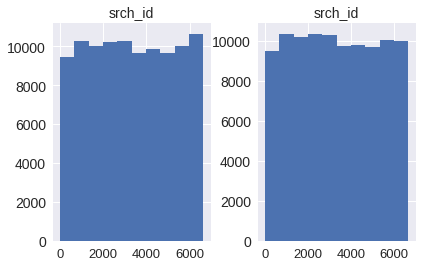

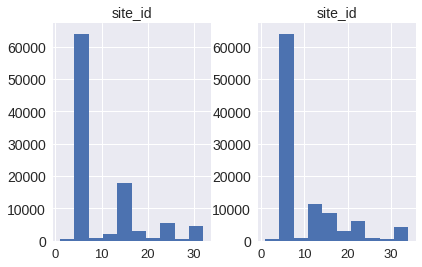

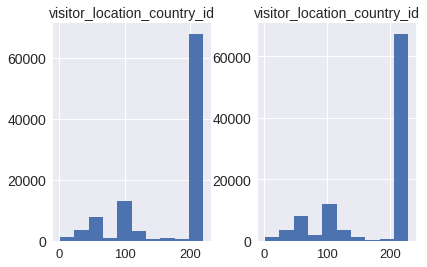

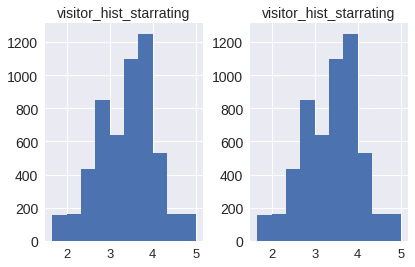

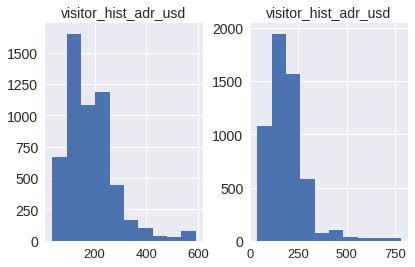

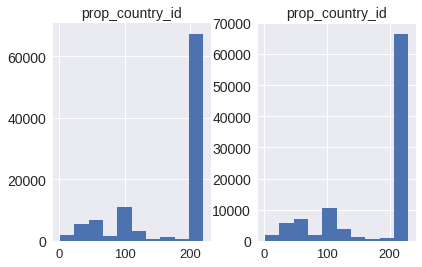

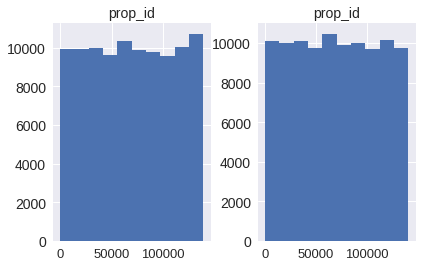

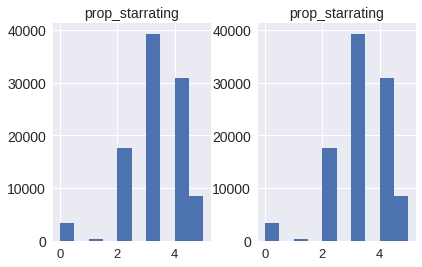

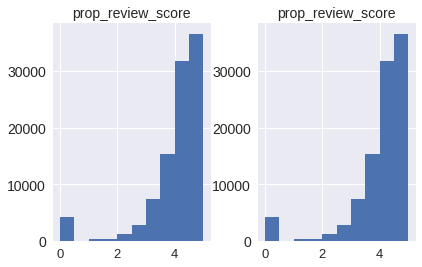

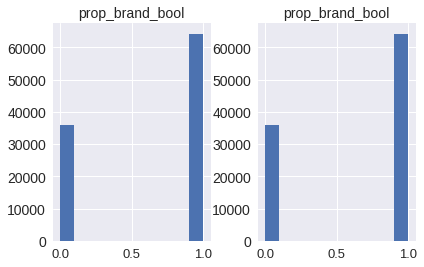

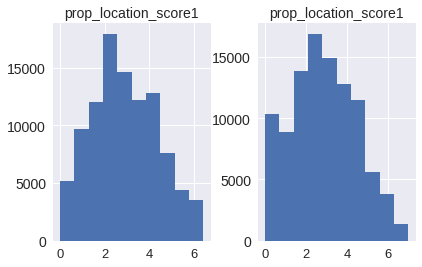

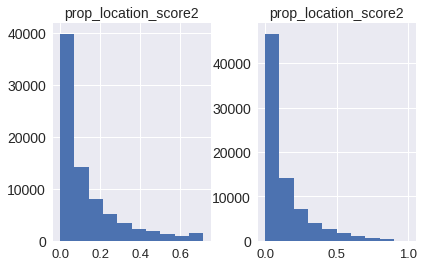

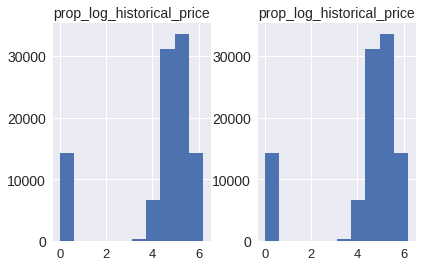

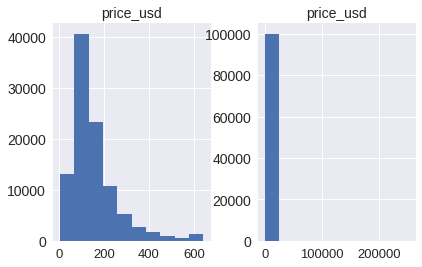

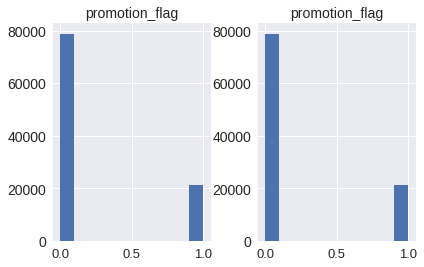

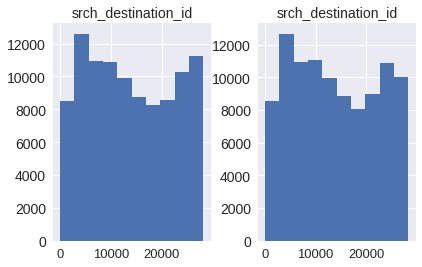

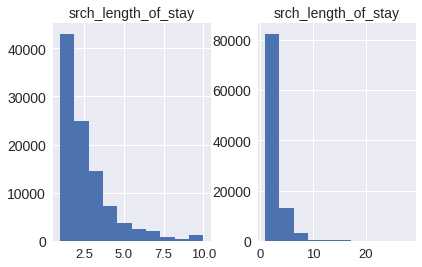

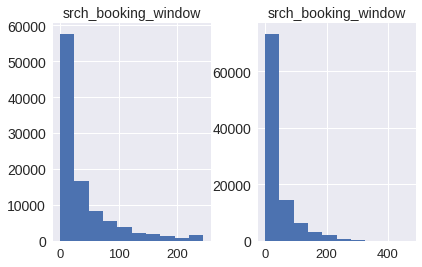

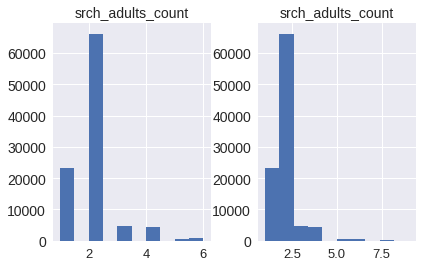

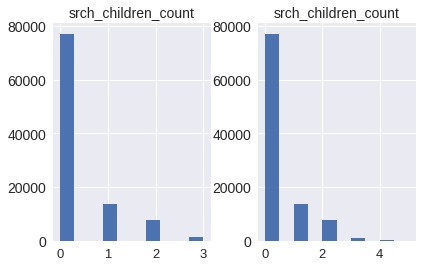

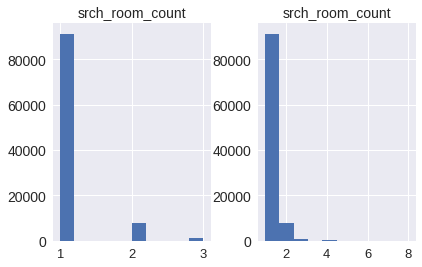

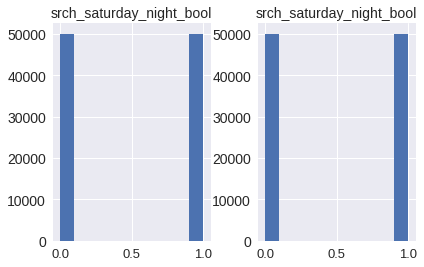

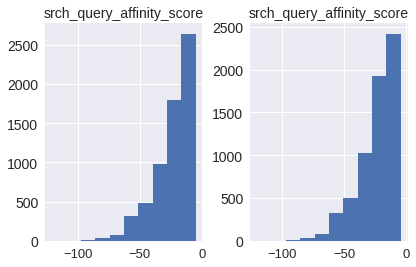

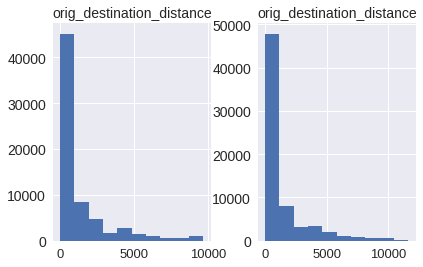

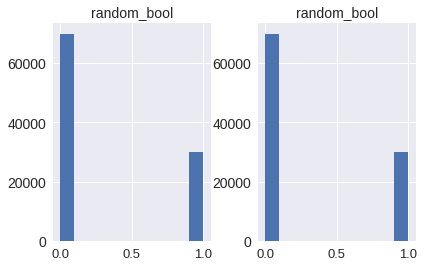

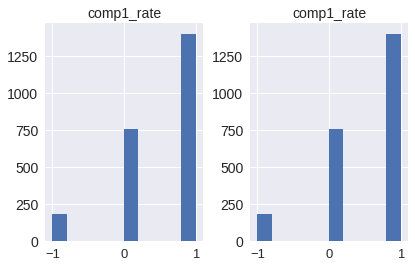

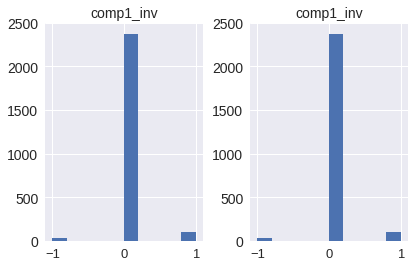

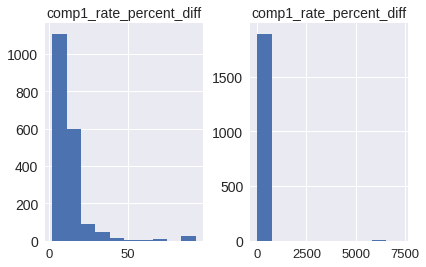

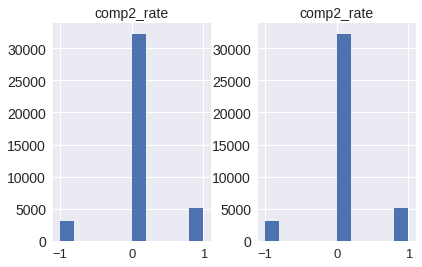

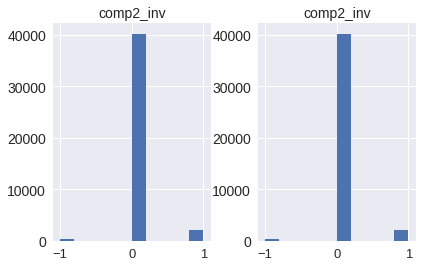

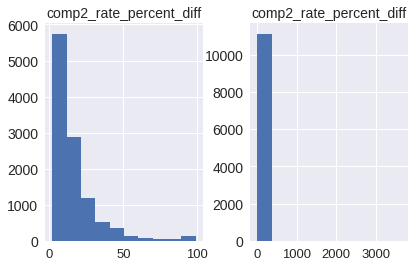

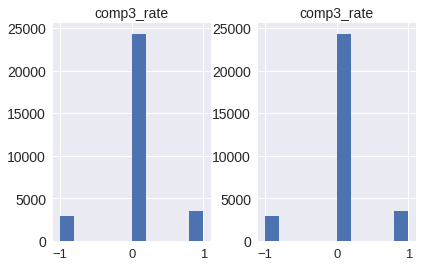

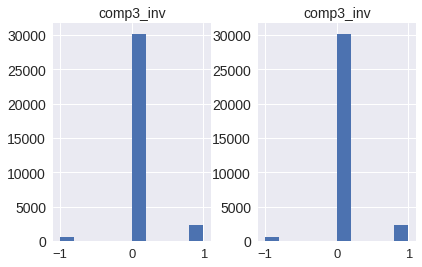

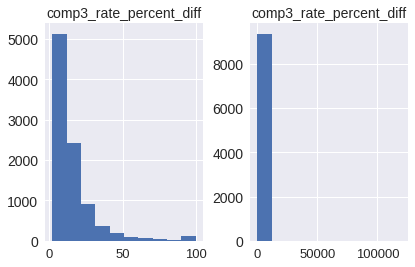

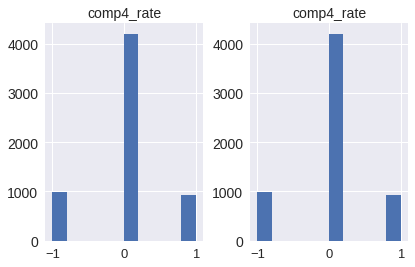

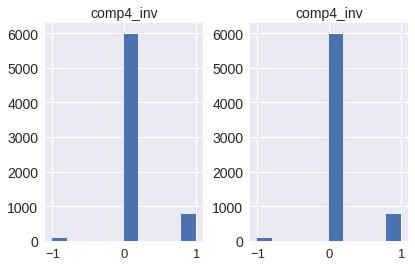

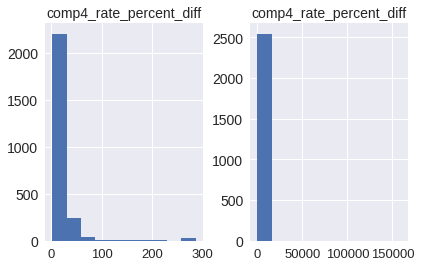

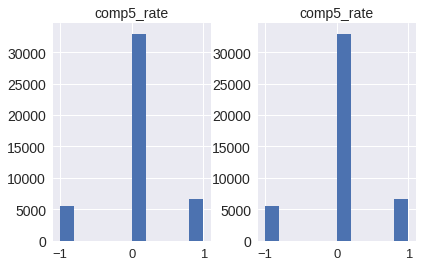

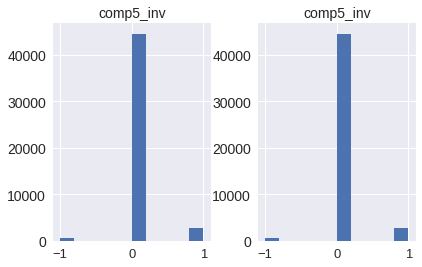

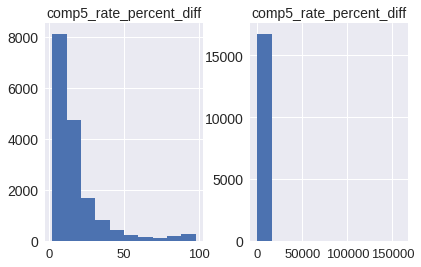

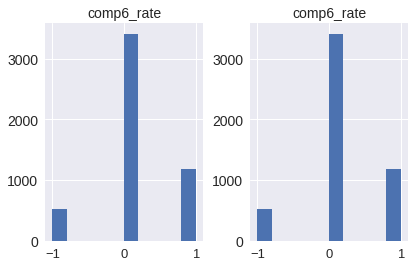

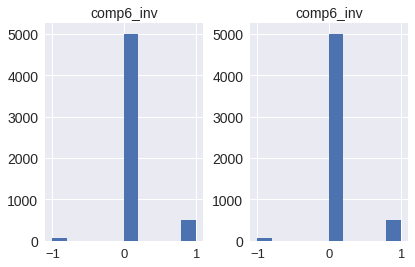

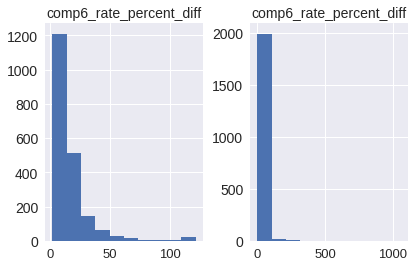

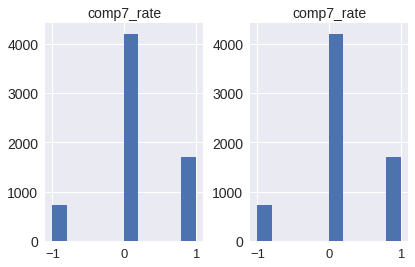

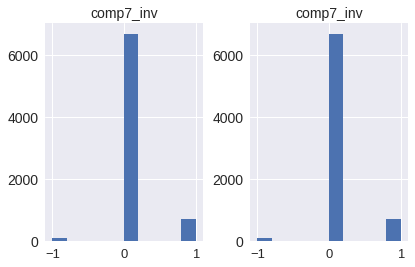

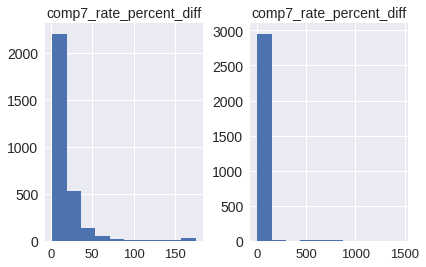

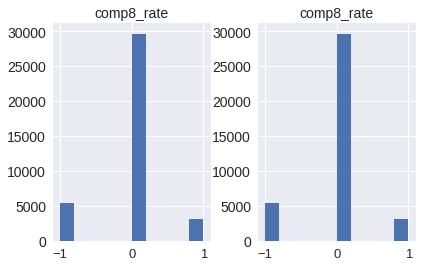

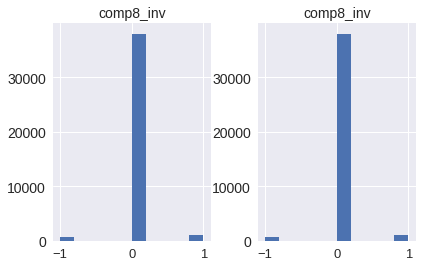

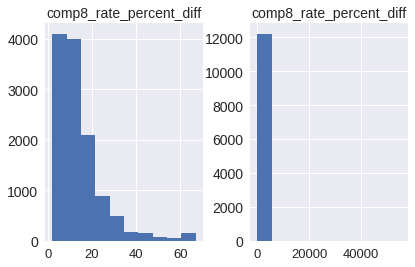

In [14]:
for feature in all_cols:
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)  
    df_before[[feature]].hist(bins=10, ax=ax2)
    df[[feature]].hist(bins=10, ax=ax1)
    plt.savefig(output_path + "hist_remove_outliers_%s.png"%feature, format='png')

    plt.show()



In [15]:
df = data_preprocessing.create_composite_features(df)
# Remove outliers before normalizing?
df = data_preprocessing.normalize_within_group(df)


In [16]:
TO_DROP = ["visitor_hist_adr_usd"]

### Set Missing values to median

In [17]:
all_cols=df.columns.drop(['booking_bool', 'click_bool', 'gross_bookings_usd', 'position'])

for feature in all_cols:
    df[feature][df[feature].isnull()] = df[feature].median()


/home/marleen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [18]:
# Subselect columns - include booking_book
summary_metrics = pd.DataFrame(df.describe())

In [19]:
df=df[list(summary_metrics.columns)]

In [20]:
summary_metrics

,srch_id,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,...,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool,price_diff_from_historic_mean,star_diff_from_historic_mean,price_rank,star_rank,value_for_money,price_usd_normalized
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.00000,2791.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,3349.125890,9.844130,175.313550,3.496481,169.257729,173.331150,70168.381110,3.199270,3.805545,0.642240,...,11.366560,0.04487,387.943823,0.027910,-29.973907,-166.319223,14.382850,14.382850,0.033086,0.358105
std,1926.275103,7.585919,66.493785,0.153513,22.675424,69.093776,40604.919775,1.048328,1.017310,0.479343,...,4.002319,0.20702,536.808535,0.164716,30.566347,22.626739,27.924234,27.924234,0.020593,0.277028
min,1.000000,1.000000,2.000000,1.670000,36.910000,2.000000,1.000000,0.000000,0.000000,0.000000,...,2.000000,0.00000,5.450000,0.000000,-572.000000,-591.180000,1.000000,1.000000,0.000000,0.000000
25%,1683.000000,5.000000,100.000000,3.500000,168.250000,100.000000,35082.500000,3.000000,3.500000,0.000000,...,11.000000,0.00000,122.740000,0.000000,-30.020000,-165.330000,6.000000,6.000000,0.020101,0.137097
50%,3314.000000,5.000000,219.000000,3.500000,168.250000,219.000000,69730.000000,3.000000,4.000000,1.000000,...,11.000000,0.00000,222.440000,0.000000,-30.020000,-165.330000,11.000000,11.000000,0.030358,0.292683
75%,5028.000000,14.000000,219.000000,3.500000,168.250000,219.000000,105276.000000,4.000000,4.500000,1.000000,...,11.000000,0.00000,430.205000,0.000000,-30.020000,-165.330000,18.000000,18.000000,0.043063,0.523438
max,6644.000000,32.000000,220.000000,5.000000,591.180000,220.000000,139366.000000,5.000000,5.000000,1.000000,...,67.000000,1.00000,7854.030000,1.000000,562.354800,-32.570000,535.000000,535.000000,0.767918,1.000000


### Calculate correlation and mutual information/information gain

### Histograms

In [393]:
#columns_to_plot=[50,12,39,42,47,48,51,53]
#g = sns.pairplot( df.iloc[1:500,columns_to_plot], hue="booking_bool",palette = 'seismic',size=5,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10),  )


## HISTOGRAMS OF VARIABLES OF INTEREST

# for feature in data.columns:
#     try:
#         data[[feature]].hist(bins=10)
#         plt.title(feature)
#         plt.savefig(output_path + "hist_%s_original.png"%feature, format='png')
#         plt.show()

#     except:
#         pass

# for feature in df.columns:
#     try:
#         data[[feature]].hist(bins=10)
#         plt.title(feature)
#         plt.savefig(output_path + "hist_%s_new.png"%feature, format='png')
#         plt.show()

#     except:
#         pass




## Distribution of each feature for booked and not booked hotels
Helps find the most discriminative features

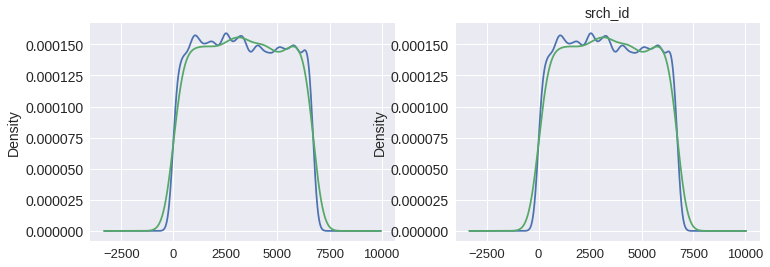

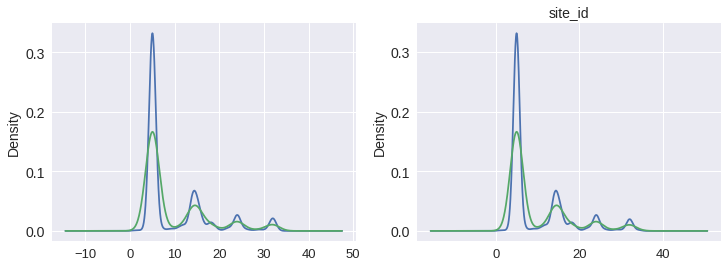

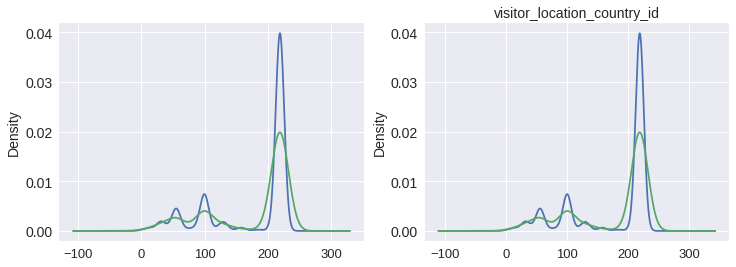

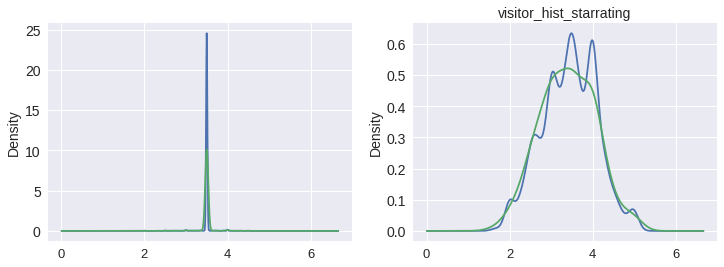

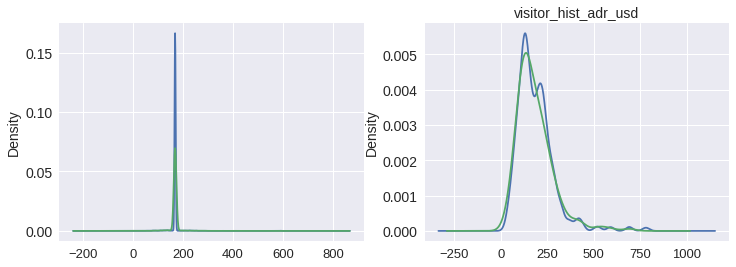

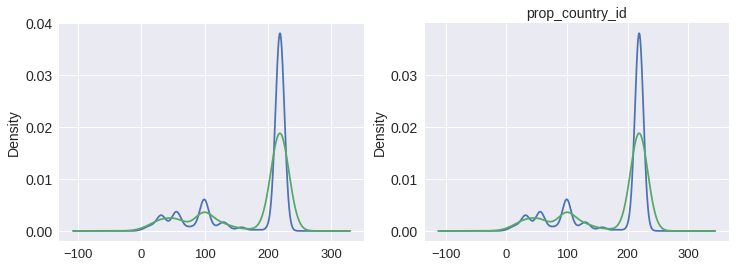

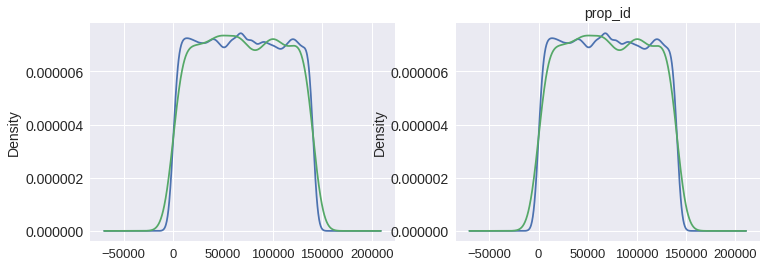

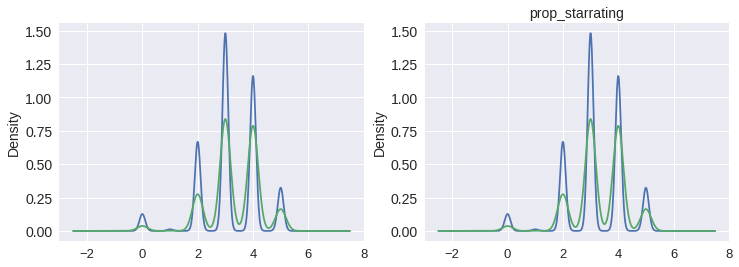

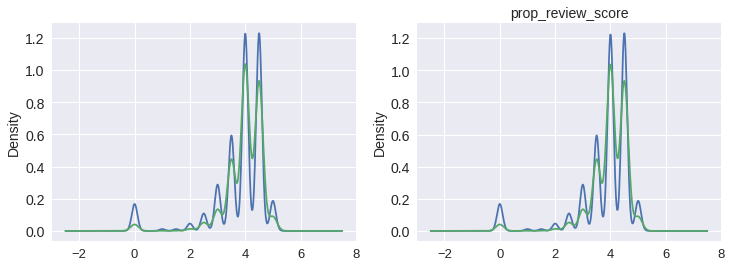

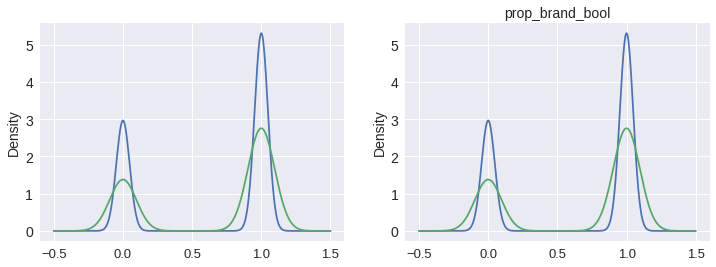

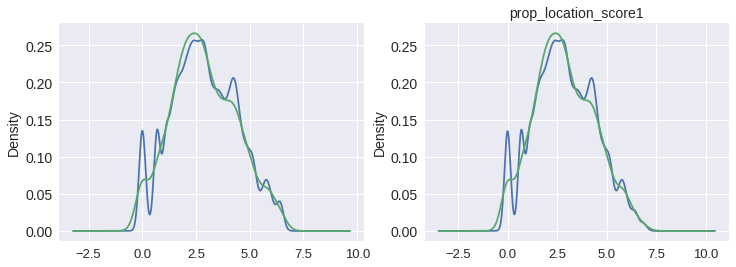

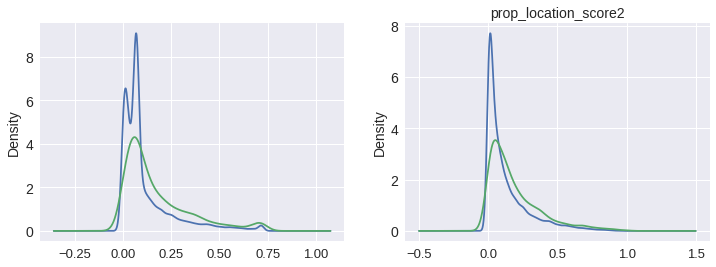

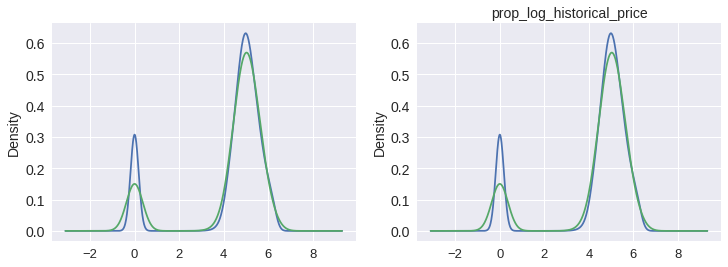

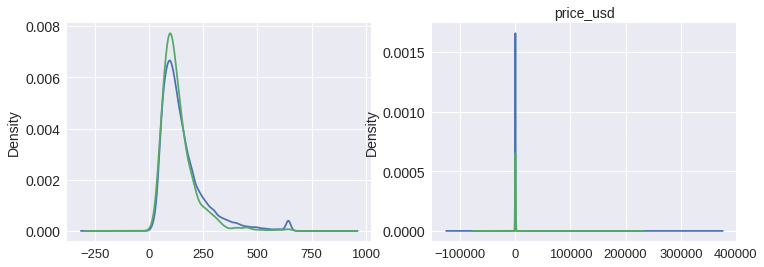

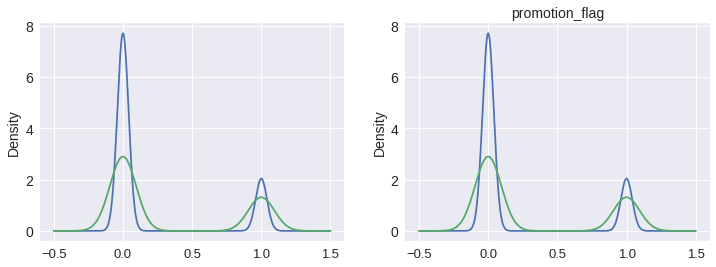

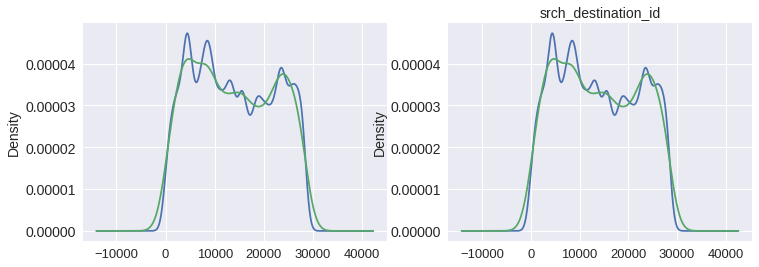

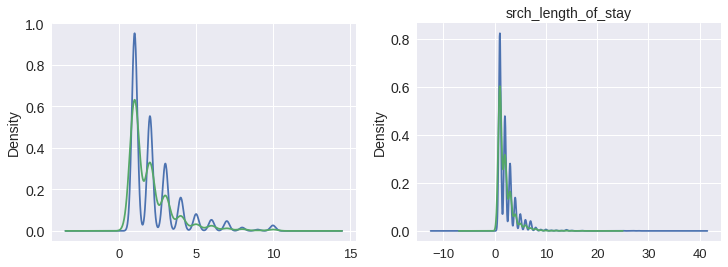

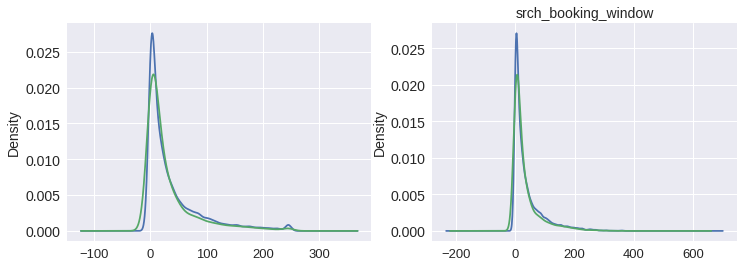

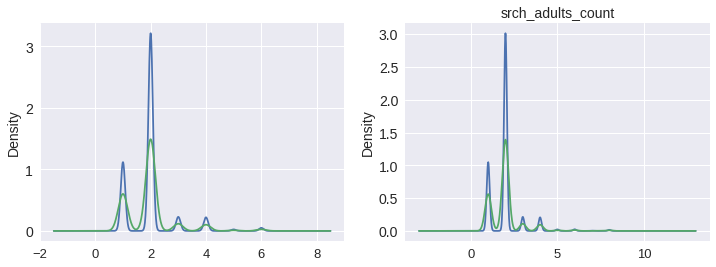

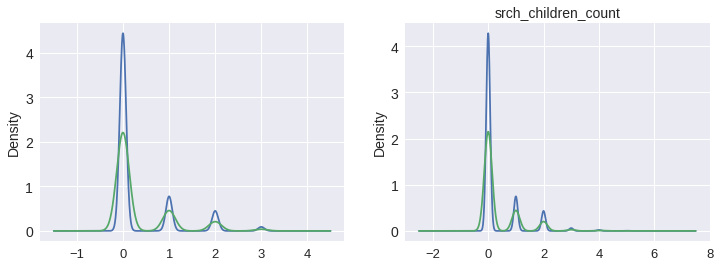

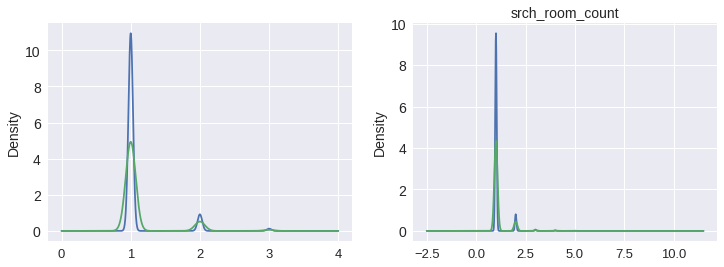

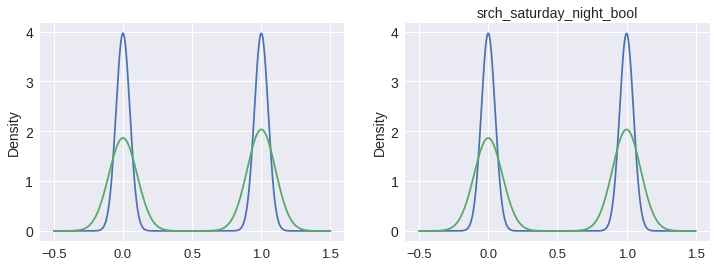

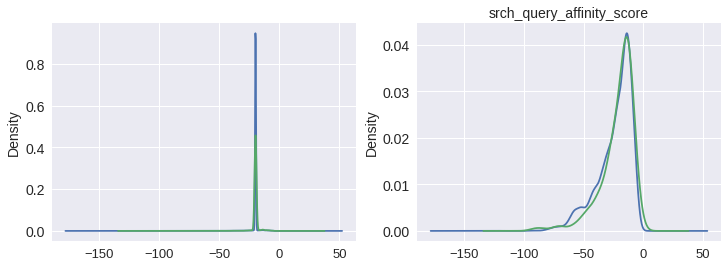

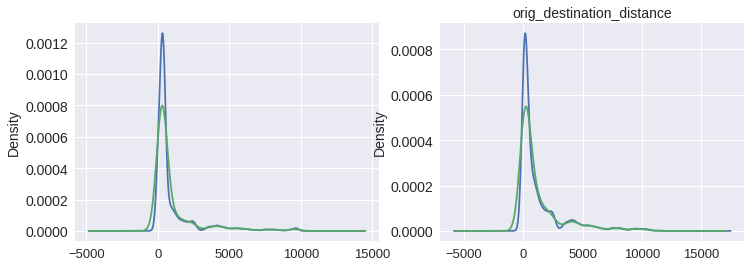

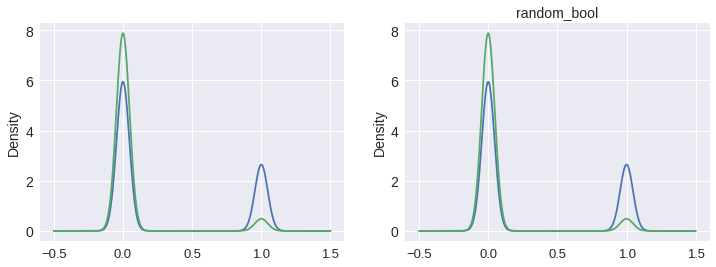

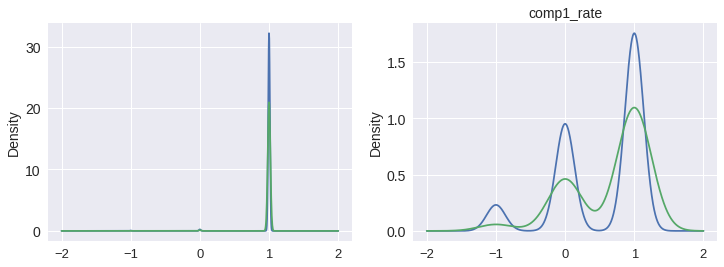

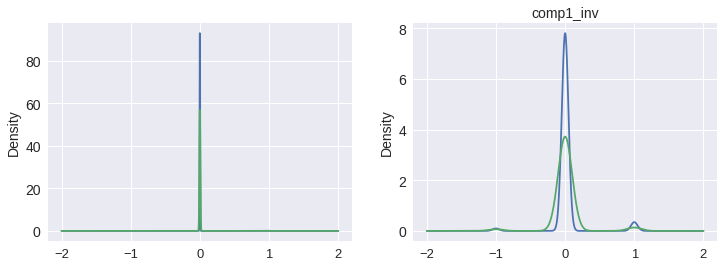

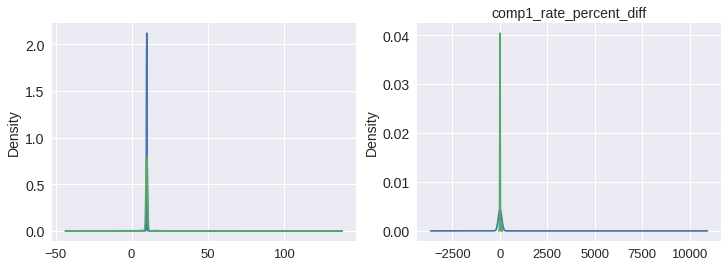

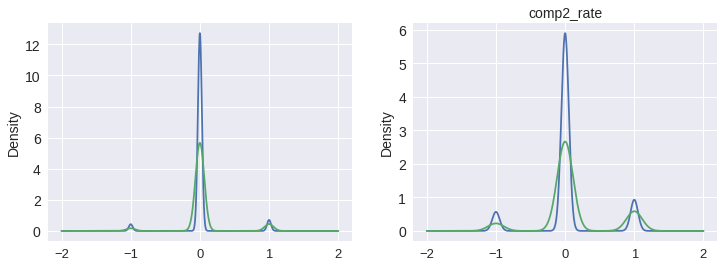

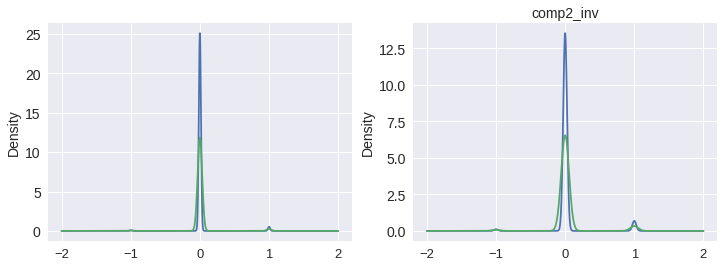

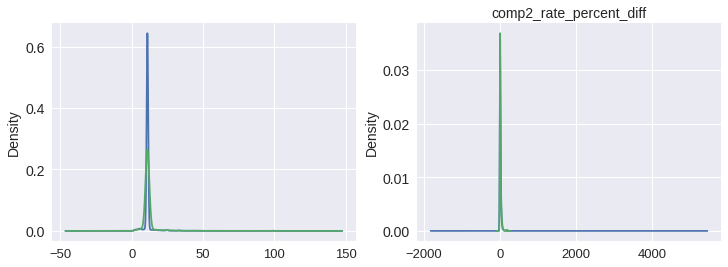

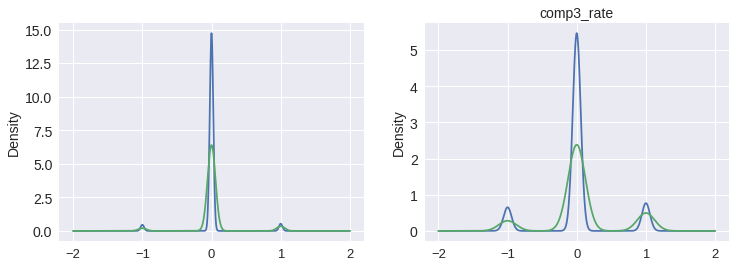

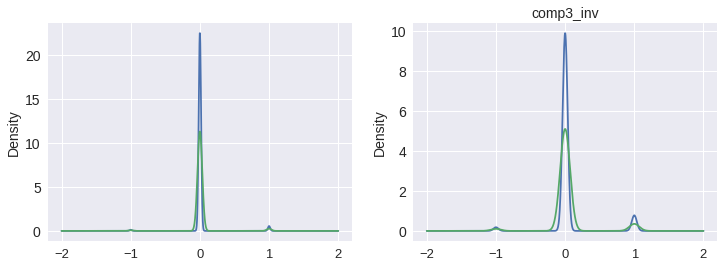

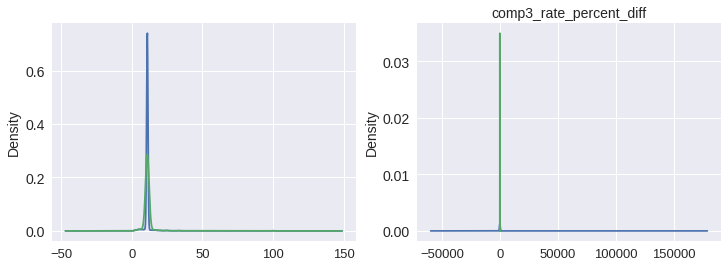

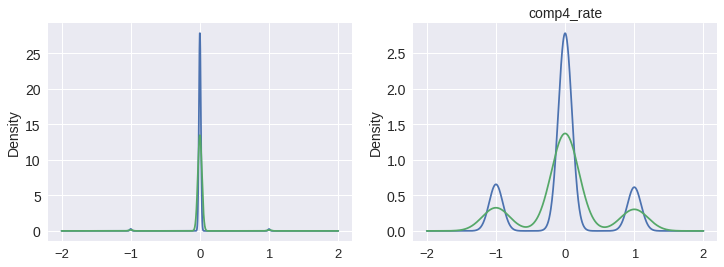

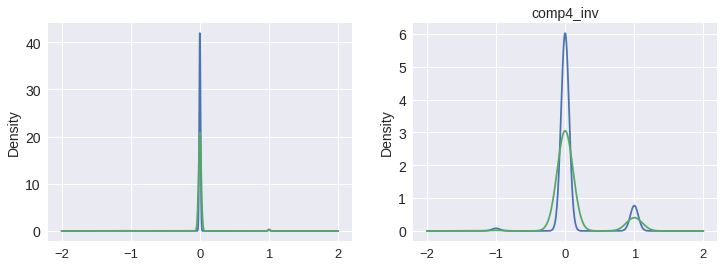

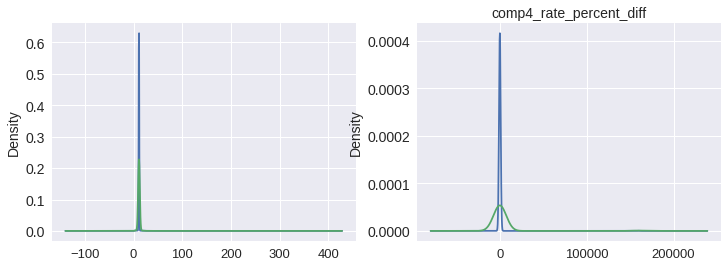

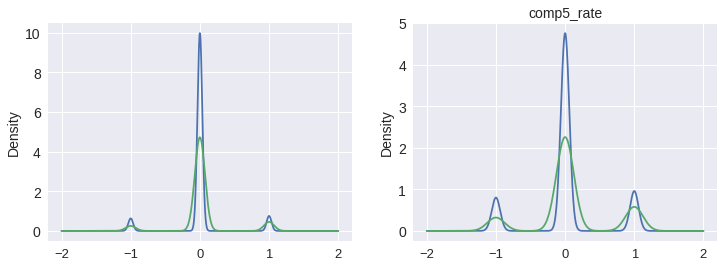

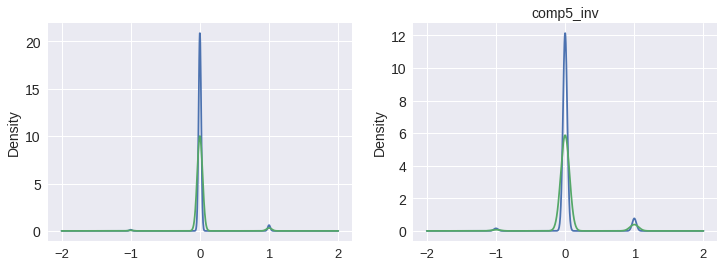

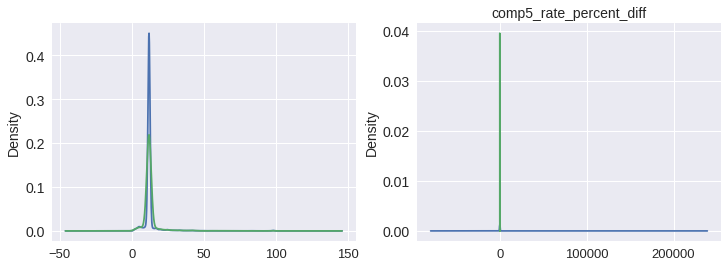

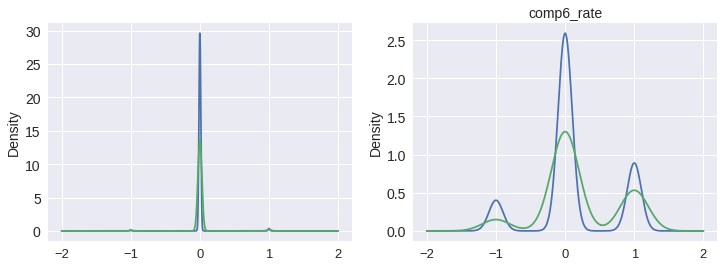

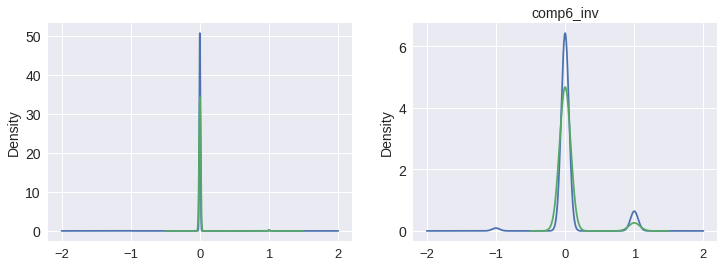

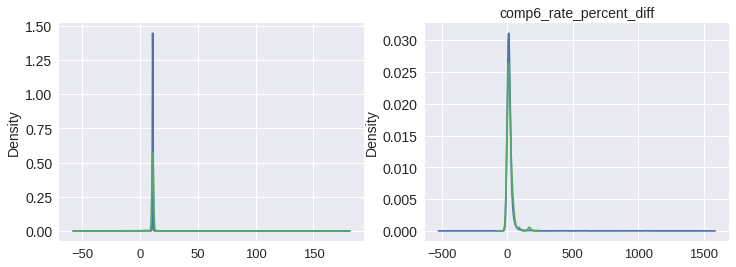

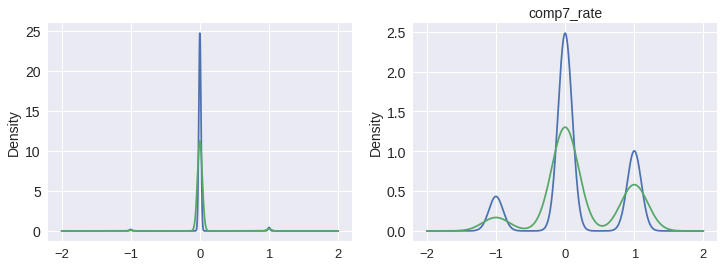

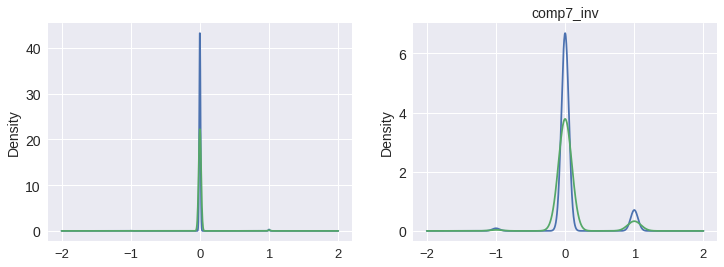

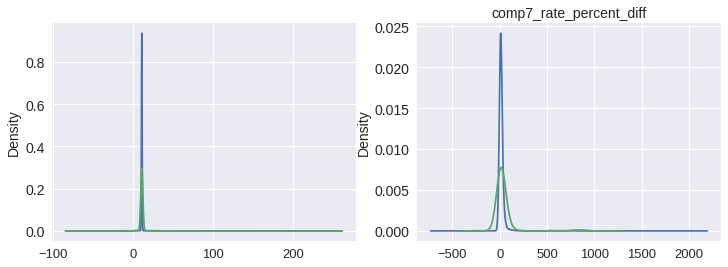

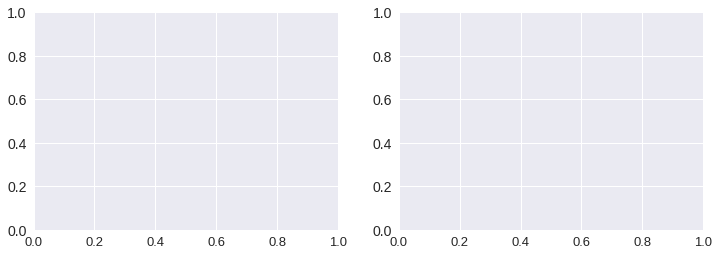

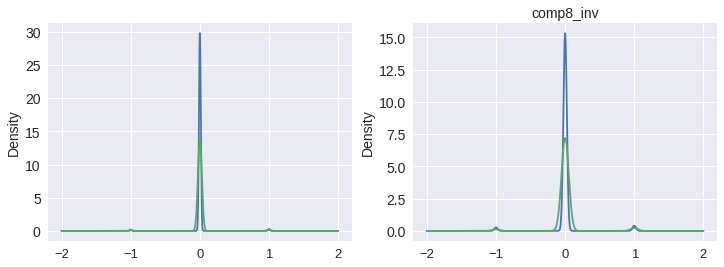

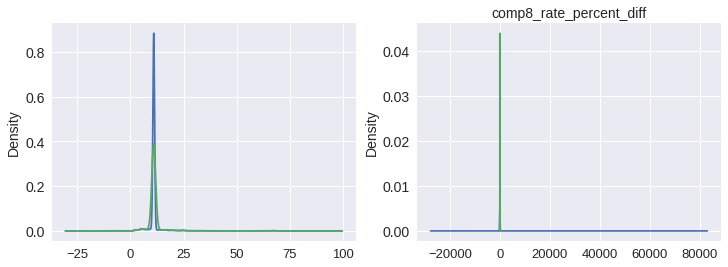

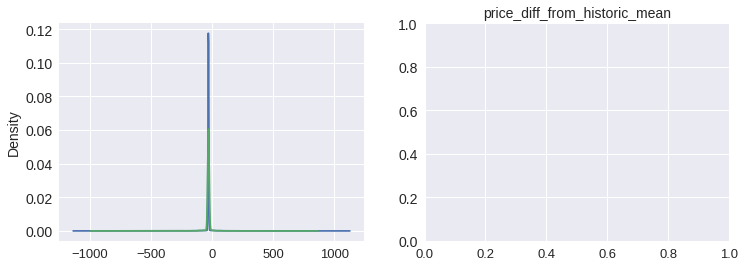

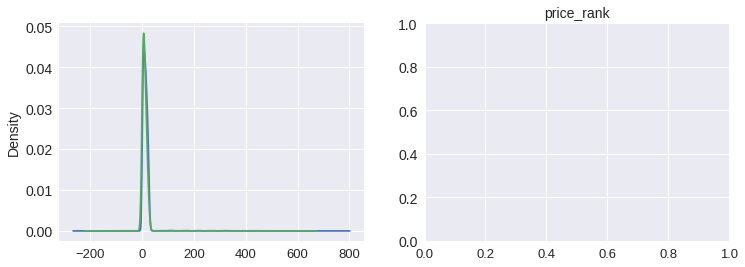

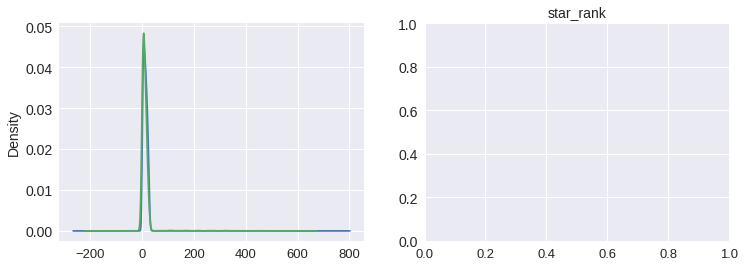

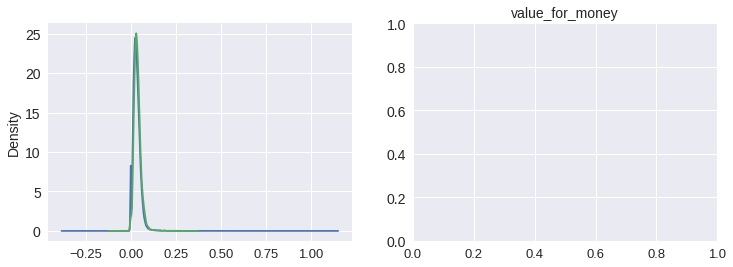

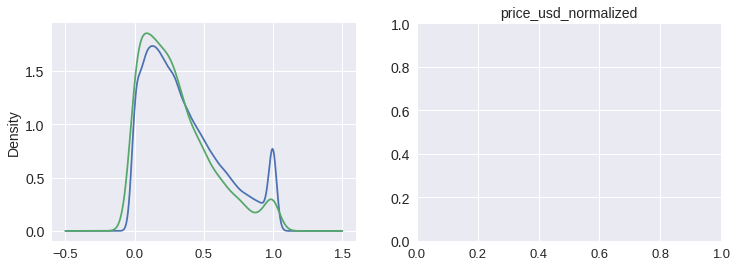

In [24]:
all_cols=df.columns.drop(['booking_bool', 'click_bool', 'gross_bookings_usd', 'position'])

for feature in all_cols:
    try:
        fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))  
        df.groupby("booking_bool")[feature].plot(kind='kde', ax=ax1)
        plt.title(feature)

        data.groupby("booking_bool")[feature].plot(kind='kde', ax=ax2)
        plt.savefig(output_path + "densityplot_before_after_%s.png"%feature, format='png')
        plt.show()
    except:
        pass


### Comments and Findings

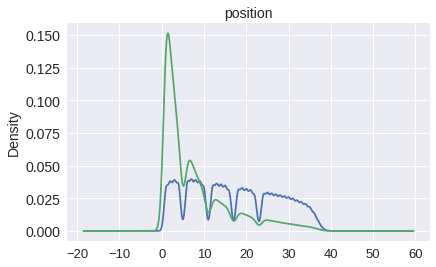

In [41]:
discriminative_features = ['position']

feature = discriminative_features[0]
df.groupby("booking_bool")[feature].plot(kind='kde')
plt.title(feature)
plt.show()

In [21]:
 all_cols

Index(['srch_id', 'site_id', 'visitor_location_country_id',
       'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_country_id',
       'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool',
       'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'srch_query_affinity_score',
       'orig_destination_distance', 'random_bool', 'comp1_rate', 'comp1_inv',
       'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv',
       'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
       'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
       'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv',
       'co

## Mutual information with booking 
Gives the most important features based on univariate statistics

In [22]:
all_cols = df.columns.drop(['booking_bool', 'click_bool', 'gross_bookings_usd', 'position'])


In [23]:
from sklearn.feature_selection import mutual_info_classif

mutual_information_click = mutual_info_classif(df[all_cols], df[['click_bool']], discrete_features='auto', n_neighbors=3, copy=True, random_state=None)
click_df = pd.DataFrame(mutual_information_click.flatten(), columns = ['mutual_info'])
click_df['feature'] = df[all_cols].columns.values

mutual_information_book = mutual_info_classif(df[all_cols], df[['booking_bool']], discrete_features='auto', n_neighbors=3, copy=True, random_state=None)
book_df = pd.DataFrame(mutual_information_book.flatten(), columns = ['mutual_info'])
book_df['feature'] = df[all_cols].columns.values



/home/marleen/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/marleen/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


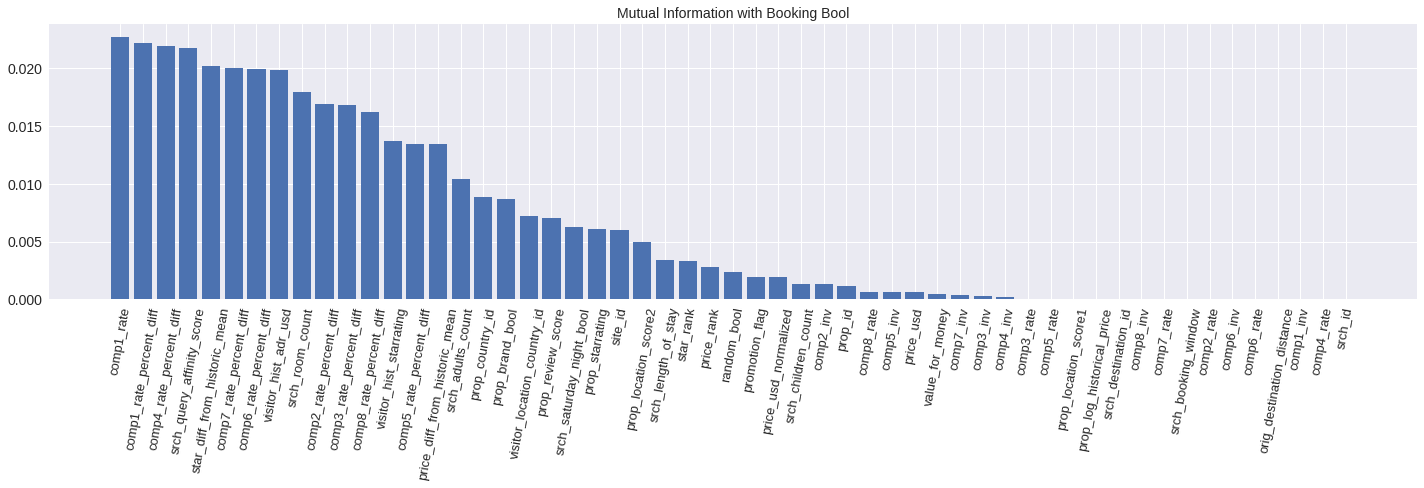

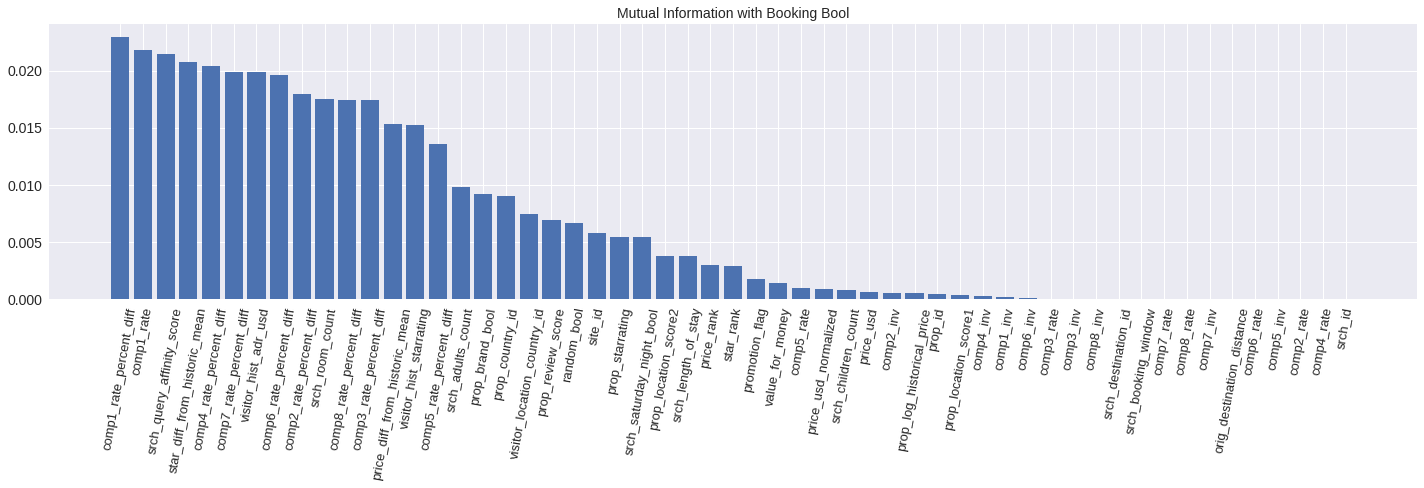

In [34]:
ind = np.arange(len(mutual_information_book))
fig, ax = plt.subplots(figsize=(20,7)) 

plt.bar(ind, click_df.sort_values('mutual_info', ascending=False)['mutual_info'])
plt.xticks(ind,click_df.sort_values('mutual_info', ascending=False)['feature'], rotation=80)
plt.title('Mutual Information with Booking Bool')
plt.tight_layout()
plt.savefig(output_path + "MutualInformation_click_bool.png", format='png')
plt.show()



ind = np.arange(len(mutual_information_click))
fig, ax = plt.subplots(figsize=(20,7)) 

plt.bar(ind, book_df.sort_values('mutual_info', ascending=False)['mutual_info'])
plt.xticks(ind,book_df.sort_values('mutual_info', ascending=False)['feature'], rotation=80)
plt.title('Mutual Information with Booking Bool')
plt.tight_layout()
plt.savefig(output_path + "MutualInformation_book_bool.png", format='png')
plt.show()

In [28]:
features_to_keep = ['booking_bool', 'click_bool', 'srch_id']
selected_features = ['value_for_money','star_diff_from_historic_mean', 'price_usd_normalized','price_rank','price_diff_from_historic_mean', 'star_rank', 'prop_review_score', 'position',
                     'prop_brand_bool', 'prop_location_score1', 'comp1_rate_percent_diff']

all_possible_features = selected_features+features_to_keep

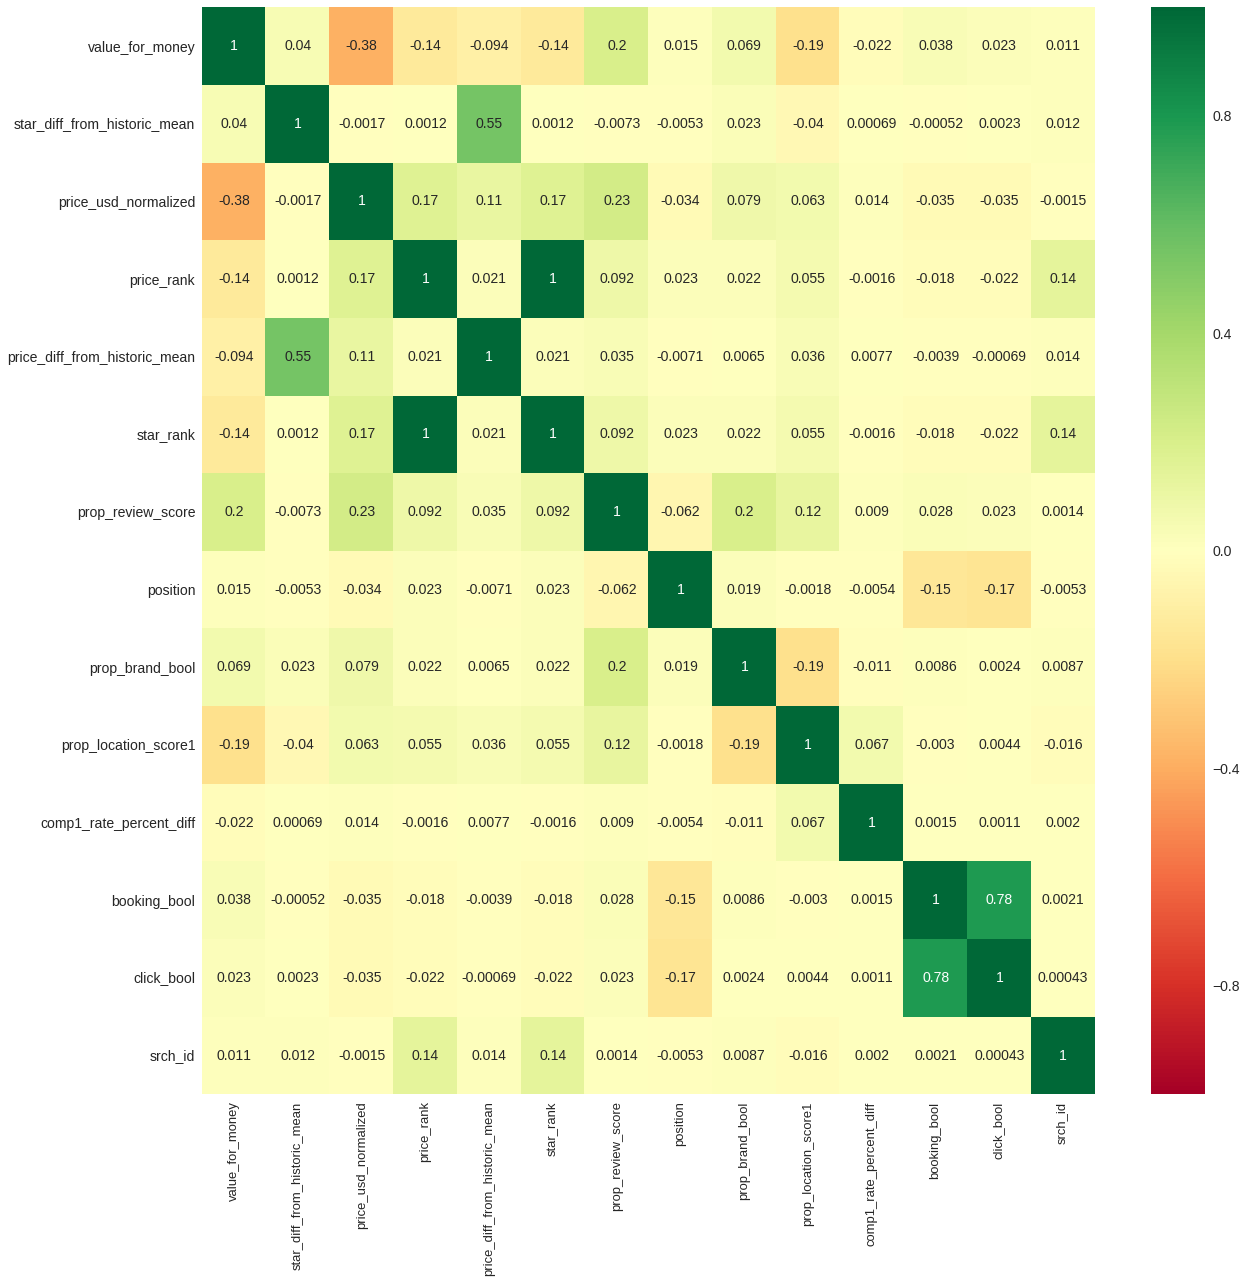

In [29]:
def plot_corr(data):
    correlation = data.corr()
    fig, ax = plt.subplots(figsize=(20,20)) 
    sns.heatmap(correlation, annot=True, cbar=True, cmap="RdYlGn")
    plt.savefig(output_path + "correlation_plot.png", format='png')

plot_corr(df[all_possible_features])





In [30]:
selected_features = ['value_for_money','price_usd_normalized', 'star_rank']
features_to_keep = ['booking_bool', 'click_bool', 'srch_id']
all_possible_features = selected_features+features_to_keep
df_to_train = df.ix[:,all_possible_features]

df_to_train['relevance']=df_to_train.booking_bool+df_to_train.click_bool

for feature in all_possible_features:
    df_to_train[feature][df_to_train[feature].isnull()] = df_to_train[feature].median()




/home/marleen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
/home/marleen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/marleen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/marleen/ana

In [31]:
relevance_arr = np.array(df_to_train.relevance)
feature_arr = np.array(df_to_train[selected_features])
id_arr = np.array(df_to_train.srch_id)

In [409]:
import pyltr
metric = pyltr.metrics.NDCG(k=10)

model = pyltr.models.LambdaMART(
    metric=metric,
    n_estimators=1000,
    learning_rate=0.02,
    max_features=0.5,
    query_subsample=0.5,
    max_leaf_nodes=10,
    min_samples_leaf=64,
    verbose=1,
)

model.fit(feature_arr, relevance_arr, id_arr)

 Iter  Train score  OOB Improve    Remaining                           Monitor Output 
    1       0.1589       0.0854        5.10m                                         
    2       0.2204       0.0517        4.74m                                         
    3       0.2345      -0.0116        4.65m                                         
    4       0.2520       0.0217        4.67m                                         
    5       0.2518       0.0208        4.65m                                         
    6       0.2933       0.0008        4.63m                                         
    7       0.2976      -0.0051        4.66m                                         
    8       0.3172      -0.0012        4.62m                                         
    9       0.2750      -0.0035        4.63m                                         
   10       0.3219      -0.0036        4.63m                                         
   15       0.3296      -0.0074        4.61m         

## Missing values

# Build Model and classifier

In [32]:
## Finalise the dataset
final_df=df_to_train

# Choose setting 
mode = 'Full' # 'Full' or 'partial'
model_to_plot=0 # 0 or 1
mode = 'partial'

# For SVM use Age continuous as it can learn nonlinear relationships
#selected_features =["Pclass", "Sex", "Age*Class", "Fare_Per_Person", "hasCabin", 
#                    "Title","Survived",
#                   "Family_Size", "Embarked", "Age"]

select = ['booking_bool']
auc = []

models_names = [ 'LogisticRegression', 'RandomForestClassifier', 'KNeighborsClassifier' ]
metric = 'roc_auc'
cv=4
models = [ LogisticRegression,  RandomForestClassifier , SVC]


In [33]:
i = 0
model_to_plot = 1
class_predict = "booking_bool"
all_possible_features = selected_features       
for feature in all_possible_features:
    print(i)
    select.append(feature)
    print(select)
    full_set = final_df[select]

    # First split the data into train and test

    # Extract the train and test from the new data_frame
    cols = list(set(full_set.columns) - set([class_predict]))
    X_train = full_set[:][cols]
    y_train = full_set[:][class_predict]
    
        # Running some models, testing with small cross_validation and f1 metric (binary target) and running the prediction
    # with all the training set
    
    mscores = []
    lscores = ['f1','accuracy','recall','roc_auc']
    np.random.seed(42) # Reproducibility of results is very important!
    for elem in models:
        mscores2 = []
        model = elem()
        for sc in lscores:
            scores = cross_val_score(model, X_train, y_train, scoring=sc, cv=cv)
            #y_pred = cross_val_predict(model, X_train, y_train, scoring=sc, cv=cv)
            #conf_mat = confusion_matrix(y_train,y_pred)
            
            mscores2.append(np.mean(scores))
            mscores.append(mscores2)
       # model_predict(model, X_train, y_train, mode)       
    scores = pd.DataFrame(mscores, columns=lscores)
    print(scores.ix[model_to_plot,metric])
    auc.append(scores.ix[model_to_plot,metric])

plt.plot(auc)
plt.ylabel(metric)
plt.title(models_names[model_to_plot])
plt.xticks(np.arange(len(all_possible_features)), all_possible_features,  rotation=45)
plt.savefig(output_path + "auc_by_feature_%s_%s_cv%s.png"%(models_names[model_to_plot], mode, cv), format='png')
plt.tight_layout()  
plt.show()
    

0
['booking_bool', 'value_for_money']


/home/marleen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/marleen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/marleen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/marleen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/marleen/anaconda3/lib/python3.6/site-packages/skle

0.577661084017
0
['booking_bool', 'value_for_money', 'price_usd_normalized']


/home/marleen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/marleen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/marleen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/marleen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/marleen/anaconda3/lib/python3.6/site-packages/skle

KeyboardInterrupt: 

# Trying out some models

In [57]:
# select relevant features from the dataset
df = df

# save dataset as csv
df.to_pickle('cleaned_dataset')
selected_features = ['value_for_money','price_rank', 'star_diff_from_historic_mean','comp1_rate_percent_diff']
features_to_keep = ['booking_bool', 'click_bool', 'srch_id']
all_possible_features = selected_features+features_to_keep
df_to_train = df.ix[:,all_possible_features]

# add relevance column to dataset
df_to_train['relevance']=df_to_train.booking_bool+df_to_train.click_bool
df_to_train=df_to_train.drop(['click_bool','booking_bool'],axis=1)
# df_to_train.drop(['booking_bool'])

# replace nulls, nans by medians
for feature in selected_features:
    df_to_train[feature][df_to_train[feature].isnull()] = df_to_train[feature].median()

# extract the train and test 
class_predict = 'relevance'
cols = list(set(df_to_train.columns) - set([class_predict]))

X_train = df_to_train[:][cols]
y_train = df_to_train[:][class_predict]

# compute different scores 
# lscores = ['f1','accuracy','recall','roc_auc']
lscores = ['accuracy']
np.random.seed(42) # reproducibility 

model = RandomForestClassifier()

clf = model.fit(X_train, y_train)
# y_pred = cross_val_predict(model, X_train, y_train, cv=cv)
    #conf_mat = confusion_matrix(y_train,y_pred)
#     print(sc, np.mean(scores))
#     print(y_pred)
#     model.predict_proba()
# model_predict(model, X_train, y_train, mode)       

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
# print('Accuracy of Decision Tree classifier on test set: {:.2f}'
#      .format(clf.score(X_test, y_test)))



    

/home/marleen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Accuracy of Decision Tree classifier on training set: 0.99
